In [64]:
files = !ls ../output/MNLI/mturk
files

['categories1.png',
 'cleaned_100000_fine-tuned_content-words_gold-label_beam_MNLI_labeled.csv',
 'cleaned_100000_fine-tuned_data-slices_gold-label_beam_MNLI_labeled.csv',
 'cleaned_100000_fine-tuned_gradient_gold-label_beam_MNLI_labeled.csv',
 'instances1.png',
 'label-flips1.png',
 'test.png']

In [1]:
# read data
import pandas as pd
import os
from ast import literal_eval as make_tuple
from collections import Counter
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

random.seed(1996)

cont = pd.read_csv('../output/MNLI/mturk/' + 'cleaned_100000_fine-tuned_content-words_gold-label_beam_MNLI_labeled.csv')
sli = pd.read_csv('../output/MNLI/mturk/' + 'cleaned_100000_fine-tuned_data-slices_gold-label_beam_MNLI_labeled.csv')
grad = pd.read_csv('../output/MNLI/mturk/' + 'cleaned_100000_fine-tuned_gradient_gold-label_beam_MNLI_labeled.csv')

grad = grad[['line-num', 'tokens-masked', 'premise', 'hypothesis', 'mask-filled', 'gold-label', 'new-label', 'flip-class']]
sli = sli[['line-num', 'tokens-masked', 'premise', 'hypothesis', 'mask-filled', 'gold-label', 'new-label', 'flip-class']]
cont = cont[['line-num', 'tokens-masked', 'premise', 'hypothesis', 'mask-filled', 'gold-label', 'new-label', 'flip-class']]

In [2]:
print(grad.shape)
print(sli.shape)
print(cont.shape)

(66027, 8)
(53236, 8)
(66652, 8)


In [3]:
print(len(grad['line-num'].unique()))
print(len(sli['line-num'].unique()))
print(len(cont['line-num'].unique()))

6325
8272
3906


In [4]:
grad.columns

Index(['line-num', 'tokens-masked', 'premise', 'hypothesis', 'mask-filled',
       'gold-label', 'new-label', 'flip-class'],
      dtype='object')

In [18]:
# setting the number of flip-classes needed for a premise and its generations to be included
num_classes_thresh = 0

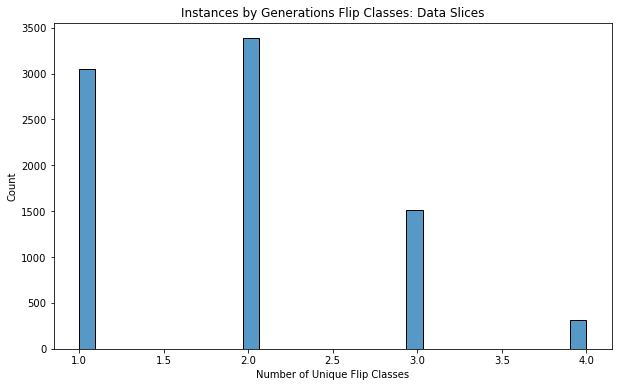

In [19]:
# getting premises that have all 4 flip label category generations.
import seaborn as sns

sli
lens = []
good_lines = pd.DataFrame()
for line in sli['line-num'].unique():
    dt = sli.loc[sli['line-num'] == line]
    lens.append(len(dt['flip-class'].unique()))
    if len(dt['flip-class'].unique()) > num_classes_thresh:
        good_lines = good_lines.append(dt)

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(lens)
plt.xlabel('Number of Unique Flip Classes')
plt.title('Instances by Generations Flip Classes: Data Slices')
plt.savefig('test.png', dpi = 100)

slice_lines = good_lines['line-num'].unique()

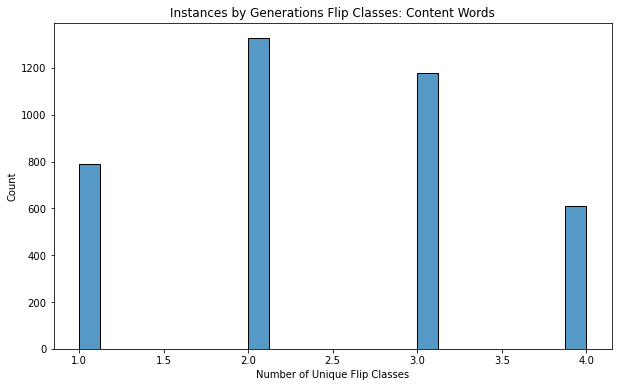

In [20]:
# getting premises that have all 4 flip label category generations.
import seaborn as sns

cont
lens = []
good_lines = pd.DataFrame()
for line in cont['line-num'].unique():
    dt = cont.loc[cont['line-num'] == line]
    lens.append(len(dt['flip-class'].unique()))
    if len(dt['flip-class'].unique()) > num_classes_thresh:
        good_lines = good_lines.append(dt)

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(lens)
plt.xlabel('Number of Unique Flip Classes')
plt.title('Instances by Generations Flip Classes: Content Words')
plt.savefig('test.png', dpi = 100)

cont_lines = good_lines['line-num'].unique()

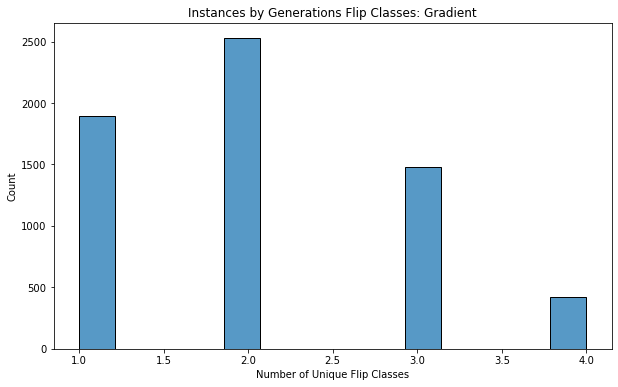

In [21]:
# getting premises that have all 4 flip label category generations.
import seaborn as sns

grad
lens = []
good_lines = pd.DataFrame()
for line in grad['line-num'].unique():
    dt = grad.loc[grad['line-num'] == line]
    lens.append(len(dt['flip-class'].unique()))
    if len(dt['flip-class'].unique()) > num_classes_thresh:
        good_lines = good_lines.append(dt)

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(lens)
plt.xlabel('Number of Unique Flip Classes')
plt.title('Instances by Generations Flip Classes: Gradient')
plt.savefig('test.png', dpi = 100)

grad_lines = good_lines['line-num'].unique()

In [22]:
print(len(slice_lines))
print(len(cont_lines))
print(len(grad_lines))

8272
3906
6325


In [23]:
# Finding 5 Gold Labeled Samples where premise is generated over all examples
prem_inds = list(set(grad['line-num'].unique()) & set(cont['line-num'].unique()) & set(sli['line-num'].unique()))

In [24]:
# where all three masking strategies have >3 flip classes, guarenteeing at least one "uncertain"
good_lines = list(set(grad_lines) & set(cont_lines) & set(slice_lines))
print(len(good_lines))

968


In [77]:
# get some high quality original gold labels for qualification round
random.shuffle(good_lines)

n_prems = 5
df = pd.DataFrame()
for premise_ind in good_lines[0:n_prems]:
    # use one of the datasets to get out good examples
    orig_sam = grad.loc[grad['line-num'] == premise_ind].drop_duplicates(['line-num'])
    
    df = df.append(pd.concat([orig_sam]))
    
print(Counter(df['gold-label']))
if len(Counter(df['gold-label'])) > 2:   
    df[['line-num', 'premise',  'hypothesis', 'gold-label']].to_csv('gold_labels_for_qualification_3-22-21.csv')

Counter({'entailment': 2, 'neutral': 2, 'contradiction': 1})


In [73]:
# get one example from each masking strategy, preferring the uncertain category
df=pd.DataFrame()

grad_s = grad.copy()
grad_s['weights'] = np.where((grad_s['flip-class'] == 'Uncertain-Same') | (grad_s['flip-class'] == 'Uncertain-Flip'), 0.85, .15)
grad_sample = grad_s.sample(n=1, weights='weights', axis = 0)


sli_s = sli.copy()
sli_s['weights'] = np.where((sli_s['flip-class'] == 'Uncertain-Same') | (sli_s['flip-class'] == 'Uncertain-Flip'), 0.85, .15)
sli_sample = sli_s.sample(n=1, weights='weights', axis = 0)


cont_s = cont.copy()
cont_s['weights'] = np.where((cont_s['flip-class'] == 'Uncertain-Same') | (cont_s['flip-class'] == 'Uncertain-Flip'), 0.85, .15)
cont_sample = cont_s.sample(n=1, weights='weights', axis = 0)

df = df.append(pd.concat([grad_sample, cont_sample, sli_sample]))
df

,line-num,tokens-masked,premise,hypothesis,mask-filled,gold-label,new-label,flip-class,weights
11165,19238,gradient,The island's quiet spot is the 12th-century Ve...,All churches on the island were torn down duri...,All churches on the island were torn down duri...,contradiction,contradiction,Certain-Same,0.15
46807,1829,content-words,Is this the other one of which you spoke? aske...,Ca'daan is unsure if this is the other one of ...,Ca'daan is wondering if this is the other one ...,entailment,entailment,Certain-Same,0.15
4215,4028,data-slices,I must say I was surprised the jury didn't bri...,The charges brought were less severe than they...,The charges brought were more severe than they...,neutral,contradiction,Uncertain-Flip,0.85


In [74]:
df.to_csv('generate_labels_for_qualification_3-22-21.csv')

In [12]:
# # same as above but without slices, which are the hardest to guarentee uncertains (strange)
# decent_lines = set(grad_lines) & set(cont_lines)
# print(len(decent_lines))

755


In [36]:
common_inds = set(cont['line-num'].unique()) & set(grad['line-num'].unique()) & set(sli['line-num'].unique())
print(len(common_inds))
common_inds = list(common_inds)

968


In [14]:
# # merge between the decent lines (which contain all the good lines) and the premises that are found in all masking strategies
# ok_lines = list(decent_lines.intersection(common_inds))
# print(len(ok_lines))

189


In [15]:
# grad = grad[grad['line-num'].isin(ok_lines)]
# cont = cont[cont['line-num'].isin(ok_lines)]
# sli = sli[sli['line-num'].isin(ok_lines)]

In [16]:
print(grad.shape)
print(cont.shape)
print(sli.shape)

(2021, 6)
(3350, 6)
(1196, 6)


In [21]:
n_rows = 203

df = pd.DataFrame()
for premise_ind in ok_lines[0:n_rows]:
    
    # getting unique flip-class for each premise (1 -> 4, expected ~3)
    grad_s = grad.loc[grad['line-num'] == premise_ind].drop_duplicates(subset=['flip-class'])
    # reweighting to favor uncertain classes in 3:1 ratio
    grad_s['weights'] = np.where((grad_s['flip-class'] == 'Uncertain-Same') | (grad_s['flip-class'] == 'Uncertain-Flip'), 0.75, .25)
    #grad_s.loc[grad_s['flip-class'] == 'Certain-Same', 'weights'] = 0.1
    grad_sam = grad_s.sample(n=1, weights = 'weights', axis = 0, random_stateint = 1996)

    cont_s = cont.loc[cont['line-num'] == premise_ind].drop_duplicates(subset=['flip-class'])
    cont_s['weights'] = np.where((cont_s['flip-class'] == 'Uncertain-Same') | (cont_s['flip-class'] == 'Uncertain-Flip'), 0.75, .25)
    #cont_s.loc[cont_s['flip-class'] == 'Certain-Same', 'weights'] = 0.1
    cont_sam = cont_s.sample(n=1, weights = 'weights', axis = 0, random_stateint = 1996)


    sli_s = sli.loc[sli['line-num'] == premise_ind].drop_duplicates(subset=['flip-class'])
    sli_s['weights'] = np.where((sli_s['flip-class'] == 'Uncertain-Same') | (sli_s['flip-class'] == 'Uncertain-Flip'), 0.75, .25)
    #sli_s.loc[sli_s['flip-class'] == 'Certain-Same', 'weights'] = 0.1
    sli_sam = sli_s.sample(n=1, weights = 'weights', axis = 0, random_stateint = 1996)
    
    # adding in original hypothesis
    orig_sam = sli_sam.copy()
    sli_sam['tokens-masked'] = ['original']
    sli_sam['mask-filled'] = sli_sam['hypothesis']
    sli_sam['flip-class'] = ['Certain-Same']
    
    # concatenating all for a given premise

    df = df.append(pd.concat([grad_sam, cont_sam, orig_sam, sli_sam]))

In [22]:
# our master batch, which we will then transform into HIT batches for MTurk

df = df.reset_index()
df

,index,line-num,tokens-masked,premise,hypothesis,mask-filled,flip-class,weights
0,6838,4096,gradient,"He may have to send cables, or something like ...",There's no possibility that he will have to se...,There's no doubt that he will have to send a c...,Uncertain-Flip,0.75
1,6383,4096,content-words,"He may have to send cables, or something like ...",There's no possibility that he will have to se...,There's no guarantee that he will have to send...,Uncertain-Flip,0.75
2,42985,4096,data-slices,"He may have to send cables, or something like ...",There's no possibility that he will have to se...,There's a possibility that he will have to sen...,Certain-Flip,0.25
3,42985,4096,original,"He may have to send cables, or something like ...",There's no possibility that he will have to se...,There's no possibility that he will have to se...,Certain-Same,0.25
4,6247,4609,gradient,Vigorously promote those legal services progra...,The highest quality programs should be kept se...,The highest quality programs should be promote...,Uncertain-Flip,0.75
...,...,...,...,...,...,...,...,...
751,4818,2554,original,"Second, mailers of some volume may be in posit...",All mailers of some volume can take advantage ...,All mailers of some volume can take advantage ...,Certain-Same,0.75
752,6272,5628,gradient,they do not get referrals from the SEC and the...,The SEC and AICPA do not give referrals for em...,The SEC and AICPA give them referrals for empl...,Uncertain-Flip,0.75
753,3859,5628,content-words,they do not get referrals from the SEC and the...,The SEC and AICPA do not give referrals for em...,The SEC and AICPA do not recommend them for em...,Uncertain-Same,0.75
754,5562,5628,data-slices,they do not get referrals from the SEC and the...,The SEC and AICPA do not give referrals for em...,The SEC and AICPA do give them referrals for e...,Uncertain-Flip,0.75


In [ ]:

df.to_csv('Pilot_Test_Master_92_3-3-21.csv')

In [16]:
Counter(df[['flip-class', 'tokens-masked']])

Counter({'flip-class': 1, 'tokens-masked': 1})

In [17]:
Counter(df['flip-class'] +'    x    ' + df['tokens-masked']).most_common(20)

[('Certain-Same    x    original', 189),
 ('Uncertain-Flip    x    gradient', 78),
 ('Uncertain-Flip    x    content-words', 63),
 ('Uncertain-Same    x    gradient', 54),
 ('Uncertain-Same    x    content-words', 54),
 ('Certain-Same    x    data-slices', 51),
 ('Uncertain-Same    x    data-slices', 50),
 ('Uncertain-Flip    x    data-slices', 47),
 ('Certain-Flip    x    data-slices', 41),
 ('Certain-Flip    x    content-words', 37),
 ('Certain-Same    x    content-words', 35),
 ('Certain-Flip    x    gradient', 29),
 ('Certain-Same    x    gradient', 28)]

In [18]:
# moving long to wide, but in a specific pattern

n_per_row = 8
n_per_strat = 4
n_samples = n_rows * n_per_strat

# starting row separations [P1M1, P2M2, P3M3, P4O, ...P8MO]
row = [0,5,10,15,16,21,26,31]

tot_batch = pd.DataFrame()

count = 0
for i in range(int(np.floor(len(df) / n_per_row))-2):
    print(count)
    print(row)
    
    shift_row = [1,1,1,-3,1,1,1-3]
    shift_row = [1,1,-3,1,1,1,-3,1]
    shift_row = [1,-3,1,1,1,-3,1,1]
    
    batch = df.loc[row] # getting specific slice 
    out_batch = pd.DataFrame() # each out batch is a HIT row 

    # getting 8 premise+hypothesis for each HIT
    for i in range(1,9):

        line = batch['line-num'].iloc[i-1]
        type = batch['tokens-masked'].iloc[i-1]
        hypo_ind = batch.index[i-1]
        prem = batch['premise'].iloc[i-1]
        mask = batch['mask-filled'].iloc[i-1]

        out_batch['premID_' + str(i)] = [line]
        out_batch['mask-type' + str(i)] = [type]
        out_batch['hypoID_' + str(i)] = [hypo_ind]
        out_batch['premise_' + str(i)] = [prem]
        out_batch['hypothesis_' + str(i)] = [mask]
    
    tot_batch = tot_batch.append(out_batch)
    
    # for same premsies, use next masking strategy [P1M2, P2M3, P3O, P4M1, ... P8M1]
    count += 1
    # yikes...need to rethink this. but it works! because of the staggered nature of the M3 -> M0 -> M2 -> M1
    if count % 4 == 0: # if all 4 examples are in the total batch, move on to next mini-batch [P9M1 ... P16M0]
        shift_row = [29,33,33,33,29,33,33,33] 
    if count % 4 == 1:
        shift_row = [1,1,1,-3,1,1,1,-3]
    if count % 4 == 2:
        shift_row = [1,1,-3,1,1,1,-3,1]
    if count % 4 == 3:
        shift_row = [1,-3,1,1,1,-3,1,1]
    
    row = [a + b for a, b in zip(row, shift_row)]
   

0
[0, 5, 10, 15, 16, 21, 26, 31]
1
[1, 6, 11, 12, 17, 22, 27, 28]
2
[2, 7, 8, 13, 18, 23, 24, 29]
3
[3, 4, 9, 14, 19, 20, 25, 30]
4
[32, 37, 42, 47, 48, 53, 58, 63]
5
[33, 38, 43, 44, 49, 54, 59, 60]
6
[34, 39, 40, 45, 50, 55, 56, 61]
7
[35, 36, 41, 46, 51, 52, 57, 62]
8
[64, 69, 74, 79, 80, 85, 90, 95]
9
[65, 70, 75, 76, 81, 86, 91, 92]
10
[66, 71, 72, 77, 82, 87, 88, 93]
11
[67, 68, 73, 78, 83, 84, 89, 94]
12
[96, 101, 106, 111, 112, 117, 122, 127]
13
[97, 102, 107, 108, 113, 118, 123, 124]
14
[98, 103, 104, 109, 114, 119, 120, 125]
15
[99, 100, 105, 110, 115, 116, 121, 126]
16
[128, 133, 138, 143, 144, 149, 154, 159]
17
[129, 134, 139, 140, 145, 150, 155, 156]
18
[130, 135, 136, 141, 146, 151, 152, 157]
19
[131, 132, 137, 142, 147, 148, 153, 158]
20
[160, 165, 170, 175, 176, 181, 186, 191]
21
[161, 166, 171, 172, 177, 182, 187, 188]
22
[162, 167, 168, 173, 178, 183, 184, 189]
23
[163, 164, 169, 174, 179, 180, 185, 190]
24
[192, 197, 202, 207, 208, 213, 218, 223]
25
[193, 198, 203, 2

In [19]:
tot_batch = tot_batch.reset_index()
tot_batch

,index,premID_1,mask-type1,hypoID_1,premise_1,hypothesis_1,premID_2,mask-type2,hypoID_2,premise_2,...,premID_7,mask-type7,hypoID_7,premise_7,hypothesis_7,premID_8,mask-type8,hypoID_8,premise_8,hypothesis_8
0,0,4096,gradient,0,"He may have to send cables, or something like ...",There's no possibility that he will not have t...,4609,content-words,5,Vigorously promote those legal services progra...,...,12301,data-slices,26,and and then see that way you'll find out if t...,It hurts to find out if there's a problem.,8721,original,31,Those with more highbrow tastes should make fo...,The highest of highbrow tastes enjoy the Tel A...
1,0,4096,content-words,1,"He may have to send cables, or something like ...",There's no guarantee that he will have to send...,4609,data-slices,6,Vigorously promote those legal services progra...,...,12301,original,27,and and then see that way you'll find out if t...,It never hurts to find out if there's a problem.,8721,gradient,28,Those with more highbrow tastes should make fo...,The highest of highbrow tastes enjoy the Tel A...
2,0,4096,data-slices,2,"He may have to send cables, or something like ...",There's a possibility that he will have to sen...,4609,original,7,Vigorously promote those legal services progra...,...,12301,gradient,24,and and then see that way you'll find out if t...,and It never hurts to find out if there's a pr...,8721,content-words,29,Those with more highbrow tastes should make fo...,The highest of highbrow tastes enjoy the Tel A...
3,0,4096,original,3,"He may have to send cables, or something like ...",There's no possibility that he will have to se...,4609,gradient,4,Vigorously promote those legal services progra...,...,12301,content-words,25,and and then see that way you'll find out if t...,It never hurts to find out if there's a proble...,8721,data-slices,30,Those with more highbrow tastes should make fo...,The highest of highbrow tastes enjoy the Tel A...
4,0,1563,gradient,32,There was therefore no means of destroying a t...,A fire could not have completely destroyed a w...,9244,content-words,37,Which is cause and which is effect here is an ...,...,5159,data-slices,58,But what sinks The Hi-Lo Country is Patricia A...,The Hi-Lo County was a very good show.,1574,original,63,"Meanwhile, their pollsters skew the polls to s...",Pollsters do not change polls based on their c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0,10692,original,675,"And when he did five to seven copypastes, whic...",When he did five to seven copy pastes he felt ...,964,gradient,676,well of course being raised on the water i'd n...,...,8650,content-words,697,"It is miraculously Speech is digitized, packe...","For no more than the cost of online access, Sp...",970,data-slices,702,This initiative permits LSC to distribute gran...,Grant award letters can be distributed in only...
88,0,12242,gradient,704,"Would the prisoner, in the hottest week of a h...",Is it possible that the prisoner in such hot w...,9172,content-words,709,"There are a few farms, scattered fields marked...",...,7135,data-slices,730,because of the yeah it's a it's a dry snow it'...,I prefer the wet slushy snow and not the dry s...,7648,original,735,"In this regard, it serves as a communications ...",Management and the information systems staff w...
89,0,12242,content-words,705,"Would the prisoner, in the hottest week of a h...",Is it possible that the prisoner in the hot we...,9172,data-slices,710,"There are a few farms, scattered fields marked...",...,7135,original,731,because of the yeah it's a it's a dry snow it'...,I prefer the wet slushy snow and not the dry s...,7648,gradient,732,"In this regard, it serves as a communications ...",Management and the information systems staff w...
90,0,12242,data-slices,706,"Would the prisoner, in the hottest week of a h...",Is it possible that the prisoner in such hot w...,9172,original,711,"There are a few farms, scattered fields marked...",...,7135,gradie

In [20]:
tot_batch.to_csv('Pilot_Test_Batch_92_3-3-21.csv')

In [21]:
Counter(df['flip-class'])

Counter({'Certain-Flip': 107,
         'Uncertain-Flip': 188,
         'Certain-Same': 303,
         'Uncertain-Same': 158})